In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import spacy

import json
import os
from pathlib import Path

from datetime import datetime
from timer import Timer

In [2]:
len(os.listdir('../../data/wamex_xml'))

14647

In [3]:
# subset reports
# base_path = '../../data/subset'

# all reports
base_path = '../../data/wamex_xml'
data_path = 'vectorised_reports'

all_files = os.listdir(base_path)

In [4]:
import spacy
        
# Creating our tokenizer function
# https://towardsdatascience.com/building-a-topic-modeling-pipeline-with-spacy-and-gensim-c5dc03ffc619
def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# create our language pipeline
nlp = spacy.load("en_core_web_lg")

# import geological patterns
# from spacy.pipeline import EntityRuler

# patterns = []
# for filename in Path('../../dictionary/patterns').glob("*.json"):
#     with open(filename, encoding="utf8") as f:
#         patterns += json.load(f)

# build pattern matcher
# ruler = EntityRuler(nlp, overwrite_ents=True)
# ruler.add_patterns(patterns)

# add pipes to nlp pipeline
# nlp.add_pipe(ruler)  # pattern matcher

# we exclude the pattern matcher to save memory as we only need tokenised strings as input for gensim doc2vec

nlp.add_pipe(lemmatizer,name='lemmatizer')  # lemmatizer
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)  # remove stopwords + punctuation, return textt

In [5]:
# # load files and tokenize (batched to handle memory)
# df_list = []
# load_size = 80
# iters = 1 + (len(all_files) // load_size)

# for i in range(0,iters):
#     now = datetime.now().time()
#     print(f'\nStarting run {i}/{iters-1} ({now}): {(load_size*i)} to {(1+i)*(load_size)}')
#     with Timer():
#         if i < iters-1:
#             files = all_files[(load_size*i):((1+i)*(load_size))] # only take first n test memory
#         else:
#             print(f'final loop for {load_size*i} to end of list')
#             files = all_files[(load_size*i):]  # dont want to index error outside length of all_files
        
#         # import files
#         data = []
#         for i, file in enumerate(files):
#             try:
#                 with open(os.path.join(base_path,file)) as json_file:
#                     data.append(' '.join(json.load(json_file)))
#             except UnicodeDecodeError:
#                 print(f'UnicodeDecodeError at index {i} file {file}.')
#                 files = files[:i] + files[(i+1):]
                
#         df = pd.DataFrame(data, columns=['report'])
#         df['file'] = files
#         df = df.loc[df.report != '']
#         df['tokens'] = list(nlp.pipe(df.report.values, batch_size=80))  # adjust
#         df_list.append(df)

# # concat dataframes to list
# df = pd.concat(df_list, ignore_index=True)
# df

In [6]:
# # save extracted data
# df.to_json(os.path.join(data_path,'tokenised_reports.json'))

In [7]:
df = pd.read_json(os.path.join(data_path,'tokenised_reports.json'))
df

,report,file,tokens
0,320000 340000 360000 380000 400000 420000 6600...,a080325_fig 1 p28.1018_14675736.json,"[320000, 340000, 360000, 380000, 400000, 42000..."
1,"MAusIMM, PP Consulting Contracting Geologists ...",a077414_p27.1645_10355535.json,"[MAusIMM, PP, Consulting, Contracting, Geologi..."
2,This report details exploration carried out on...,a074282_reidy_annual2006_12863956.json,"[report, detail, exploration, carry, Reidy, Sw..."
3,CONDOR NICKEL LIMITED; PERTH FIGURE 2 TARGET G...,a080852_e27_318_2008a_14530025.json,"[CONDOR, NICKEL, LIMITED, PERTH, FIGURE, 2, TA..."
4,The Hamersley Province has undergone a complex...,a077471_e47_1265_2008a_10539959.json,"[Hamersley, Province, undergo, complex, deform..."
...,...,...,...
13172,Location: The centre of the tenement is 10.5km...,a075993_e771035_2007a_11377945.json,"[location, centre, tenement, 10.5, km, north, ..."
13173,Location 135 kilometres north of Meekatharra W...,a084199_dg_e52-1698_2009p_10625717.json,"[location, 135, kilometre, north, Meekatharra,..."
13174,Figure 1 Partial surrender Plan Figure 2 Rock ...,a084085_e45_2560_2009p_11755446.json,"[figure, 1, partial, surrender, Plan, Figure, ..."
13175,"SWAGER, C. P., 1995, Geology of the greenstone...",a083081_e28_1786_2009a_9893570.json,"[SWAGER, C., P., 1995, geology, greenstone, te..."


In [8]:
# train model
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def get_doc2vec(model, df):
    vecs = []
    for idx in df.index:
        try:
            vec = model.docvecs[idx]
        except:
            vec = np.nan
        vecs.append(vec)
        
    return vecs

model_path = os.path.join(data_path,'report2vec.model')

# with Timer():
#     tagged_data = [TaggedDocument(words=row.tokens, tags=[row.file]) for row in df.itertuples()]
#     print(f'Doc2Vec model training on {len(df)} reports starting at {datetime.now().time()}')

#     max_epochs = 100

#     #Note: dm defines the training algorithm.
#     # If dm=1 means ‘distributed memory’ (PV-DM) and dm =0 means ‘distributed bag of words’ (PV-DBOW).
#     model = Doc2Vec(vector_size=50, alpha=0.025, min_alpha=0.00025, min_count=2, dm=1, epochs=max_epochs,
#                    workers=6)

#     model.build_vocab(tagged_data)

#     model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

#     # for epoch in range(max_epochs):
#     #     print(f'starting epoch {epoch} at {datetime.now().time()}')
#     #     model.train(tagged_data, total_examples=model.corpus_count, epochs=model.iter)  # model.iter
#     #     model.alpha -= 0.0002
#     #     model.min_alpha = model.alpha

In [9]:
# model.save(model_path)

In [10]:
# document 2 vec model
report2vec = Doc2Vec.load(model_path)

In [11]:
vectors = pd.DataFrame((get_doc2vec(report2vec, df)))

In [12]:
# save vectors
# vectors.index = df.file
# vectors.to_csv('vectorised_reports.csv')
# vectors = vectors.reset_index(drop=True)

In [13]:
# define cosine classification functions
def cosine_similarity(a, b):
    magnitude = lambda x : np.sqrt(np.sum(np.power(x,2)))
    return (np.dot(a, b)) / (magnitude(a)*magnitude(b))

def cosine_distance(a, b):
    return 1 - cosine_similarity(a, b)

from itertools import product

# # calculate pairwise distance matrix with cosine distance function -- TOO SLOW
# with Timer():
#     distance_matrix = np.array([cosine_distance(a,b) for a, b in product(vectors.values, vectors.values)])
#     distance_matrix = distance_matrix.reshape(len(vectors),len(vectors))  # make square matrix
# np.fill_diagonal(distance_matrix, 0)  # inplace operation to handle floating points that are approx 0
# pd.DataFrame(distance_matrix)  # cosine distance matrix for subset reports

In [36]:
from sklearn.metrics.pairwise import pairwise_distances  # parallelised

with Timer():
    distance_matrix = pairwise_distances(X = vectors.values, metric = 'cosine', n_jobs = -1)

Elapsed time: 1.0186 seconds


In [37]:
from sklearn.cluster import dbscan

# compute dbscan for a number of different epsilon
eps_range = np.linspace(0.01, 0.3, 30).round(2)
db = [dbscan(distance_matrix, metric='precomputed', eps=eps, min_samples=2) for eps in eps_range]

# output dbscan labels to dataframe for each eps
clusters = pd.DataFrame.from_dict(
{'label':np.array([x[1] for x in db]).ravel(),
     'eps': np.repeat(eps_range, len(vectors))}
)

In [38]:
clusters.groupby('eps').apply(lambda x : x.label == -1).groupby('eps').sum()

eps
0.01    11936
0.02    10270
0.03     9094
0.04     8104
0.05     7302
0.06     6636
0.07     5965
0.08     5392
0.09     4917
0.10     4447
0.11     3980
0.12     3631
0.13     3245
0.14     2891
0.15     2588
0.16     2281
0.17     2043
0.18     1808
0.19     1585
0.20     1397
0.21     1186
0.22     1013
0.23      847
0.24      694
0.25      566
0.26      473
0.27      387
0.28      301
0.29      225
0.30      183
Name: label, dtype: int64

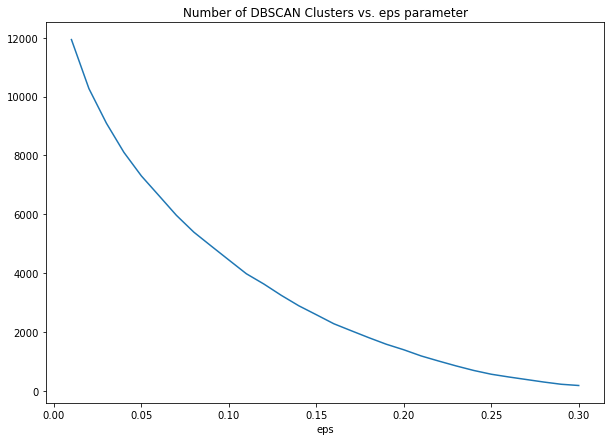

In [39]:
clusters.groupby('eps').apply(lambda x : x.label == -1).astype(int).groupby('eps').sum().plot(
    title='Number of DBSCAN Clusters vs. eps parameter', figsize=(10,7))

In [40]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2, metric='precomputed')
nbrs = neigh.fit(distance_matrix)
distances, indices = nbrs.kneighbors(distance_matrix)

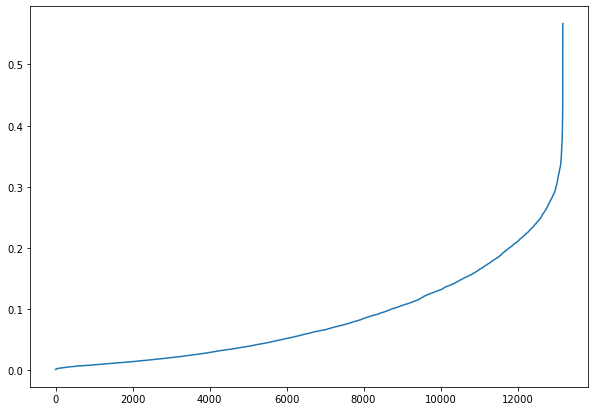

In [41]:
# look for bend in epsilon for an appropriate value to set for dbscan (seems to be around 0.2 - 0.3)
pd.Series(np.sort(distances, axis=0)[:,1]).plot(figsize=(10,7))

In [53]:
from sklearn.manifold import TSNE

# Applying the Singular value decomposition
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=10, random_state=2018)
svd_data = svd.fit_transform(vectors)
print("Dimensionality of LSA space: {}".format(svd_data.shape))

tsne = TSNE(n_jobs=6,
      early_exaggeration=4,
      n_components=2,
      verbose=1,
      random_state=2018,
      n_iter=10000)

# Putting the tsne information into a dataframe
projections = pd.DataFrame(data=tsne.fit_transform(svd_data), columns=["x", "y"])

display(projections, clusters)

import plotly.express as px

fig = px.scatter(
    projections, x='x', y='y',
    #color=clusters.loc[clusters.eps == 0.15].label, labels={'color': 'eps'}  # color is misleading,
    title = 't-SNE projection in 2D'
)

fig.show()

Dimensionality of LSA space: (13177, 10)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13177 samples in 0.009s...
[t-SNE] Computed neighbors for 13177 samples in 1.520s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13177
[t-SNE] Computed conditional probabilities for sample 2000 / 13177
[t-SNE] Computed conditional probabilities for sample 3000 / 13177
[t-SNE] Computed conditional probabilities for sample 4000 / 13177
[t-SNE] Computed conditional probabilities for sample 5000 / 13177
[t-SNE] Computed conditional probabilities for sample 6000 / 13177
[t-SNE] Computed conditional probabilities for sample 7000 / 13177
[t-SNE] Computed conditional probabilities for sample 8000 / 13177
[t-SNE] Computed conditional probabilities for sample 9000 / 13177
[t-SNE] Computed conditional probabilities for sample 10000 / 13177
[t-SNE] Computed conditional probabilities for sample 11000 / 13177
[t-SNE] Computed conditional probabilities for sample 12000 / 13177
[t-SNE] C

,x,y
0,-34.466503,-76.030563
1,-62.545116,-67.585747
2,-1.188568,-111.666504
3,-33.647282,-80.563301
4,-14.521528,128.151581
...,...,...
13172,34.581188,-32.623680
13173,22.929462,67.685753
13174,29.053816,34.627670
13175,-55.319977,-109.363731


,label,eps
0,-1,0.01
1,-1,0.01
2,-1,0.01
3,-1,0.01
4,-1,0.01
...,...,...
395305,0,0.30
395306,0,0.30
395307,0,0.30
395308,0,0.30


In [54]:
clusters.loc[clusters.eps == 0.15].label.value_counts()

 1      3639
-1      2588
 21      403
 7       287
 12      170
        ... 
 412       2
 380       2
 356       2
 300       2
 0         2
Name: label, Length: 1372, dtype: int64

In [52]:
from sklearn.manifold import TSNE

# Applying the Singular value decomposition
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=10, random_state=2018)
svd_data = svd.fit_transform(vectors)
print("Dimensionality of LSA space: {}".format(svd_data.shape))

tsne3d = TSNE(n_jobs=6,
      early_exaggeration=4,
      n_components=3,
      verbose=1,
      random_state=2018,
      n_iter=10000)

# Putting the tsne information into a dataframe
projections3d = pd.DataFrame(data=tsne3d.fit_transform(svd_data), columns=["x", "y", "z"])

display(projections)

fig3d = px.scatter_3d(
    projections, x='x', y='y', z='z',
    #color=clusters.loc[clusters.eps == 0.15].label, labels={'color': 'eps'}  # color is misleading,
    title = 't-SNE projection in 3D'
)

fig3d.show()

Dimensionality of LSA space: (13177, 10)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13177 samples in 0.009s...
[t-SNE] Computed neighbors for 13177 samples in 1.531s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13177
[t-SNE] Computed conditional probabilities for sample 2000 / 13177
[t-SNE] Computed conditional probabilities for sample 3000 / 13177
[t-SNE] Computed conditional probabilities for sample 4000 / 13177
[t-SNE] Computed conditional probabilities for sample 5000 / 13177
[t-SNE] Computed conditional probabilities for sample 6000 / 13177
[t-SNE] Computed conditional probabilities for sample 7000 / 13177
[t-SNE] Computed conditional probabilities for sample 8000 / 13177
[t-SNE] Computed conditional probabilities for sample 9000 / 13177
[t-SNE] Computed conditional probabilities for sample 10000 / 13177
[t-SNE] Computed conditional probabilities for sample 11000 / 13177
[t-SNE] Computed conditional probabilities for sample 12000 / 13177
[t-SNE] C

,x,y,z
0,-11.694599,14.640039,-4.651544
1,-8.789012,14.985982,-8.242541
2,-24.237459,1.312235,-21.849220
3,-12.892566,11.830203,-13.422159
4,13.807368,-23.002176,20.748833
...,...,...,...
13172,-11.715579,-13.608467,0.141431
13173,25.567396,6.139887,0.665482
13174,15.134041,-5.064013,-2.013690
13175,-16.551796,18.063269,-11.893475


,label,eps
0,-1,0.01
1,-1,0.01
2,-1,0.01
3,-1,0.01
4,-1,0.01
...,...,...
395305,0,0.30
395306,0,0.30
395307,0,0.30
395308,0,0.30


In [55]:
projections.to_csv(os.path.join(data_path,'projections.csv'))
projections3d.to_csv(os.path.join(data_path,'projections3d.csv'))